# Kaggle Competition: House Prices 

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

%matplotlib inline

In [56]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_id = train['Id']
test_id = test['Id']

print('Size of training data with ID and Sale Price is: {}'.format(train.shape))
print('Size of test data with ID is: {}'.format(test.shape))



Size of training data with ID and Sale Price is: (1460, 81)
Size of test data with ID is: (1459, 80)


# Outliers
From this __[document](http://jse.amstat.org/v19n3/decock.pdf)__ by the author of the dataset, outliers can be seen when we plot the sale prices versus the GrLivArea feature. He recommends removing homes where the GrLivArea is greater than 4000 square feet. 

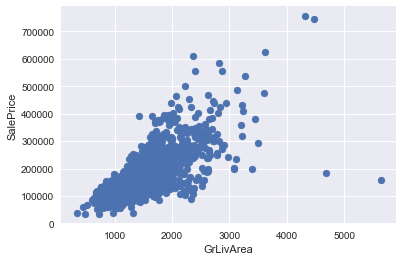

In [57]:
fig = plt.figure()
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [58]:
train = train[train['GrLivArea']<4000]
print('Training dataset size is: {}'.format(train.shape))

target = train['SalePrice']

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

print('Size of training data without ID and Sale Price is: {}'.format(train.shape))
print('Size of test data without ID is: {}'.format(test.shape))

Training dataset size is: (1456, 81)
Size of training data without ID and Sale Price is: (1456, 79)
Size of test data without ID is: (1459, 79)


Now that we have removed the major outliers from the dataset (there may be more), we will now look at the target or dependent variable, Sale Price. We will plot the distribution of the target.

/anaconda3/envs/testenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Mu: 180151.2335164835 and Sigma: 76670.24989058504


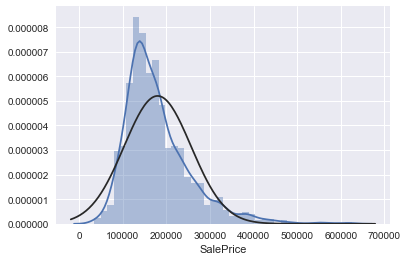

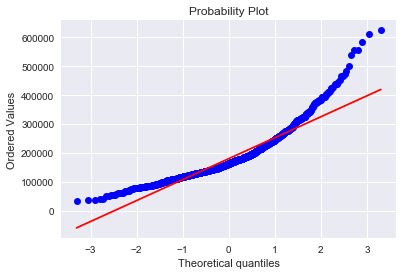

In [59]:
from scipy.stats import norm
from scipy.stats import probplot
sns.distplot(target, fit=norm)
(mu, sigma) = norm.fit(target)
print('Mu: {} and Sigma: {}'.format(mu, sigma))

fig = plt.figure()
res = stats.probplot(target, plot=plt)

plt.show()

As the target variable is positively skewed, it would be helpful to transform the target using a lognormal transform. This will cause the data to fit a more normal distribution.

Mu: 12.021943004918326 and Sigma: 0.39594380607482005


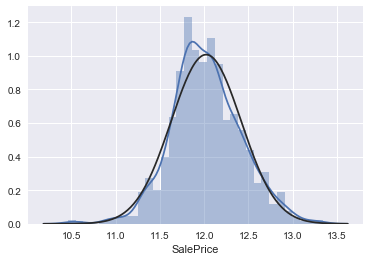

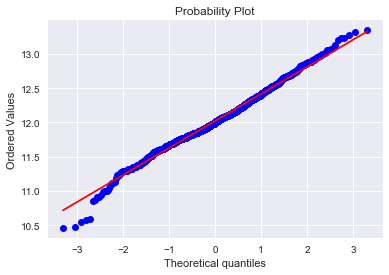

In [60]:
target = np.log(target)
(mu, sigma) = norm.fit(target)
print('Mu: {} and Sigma: {}'.format(mu, sigma))
sns.distplot(target,fit=norm)

fig = plt.figure()
res = stats.probplot(target,plot=plt)
plt.show()

# Processing the data
The target has been log transformed and now follows a more normal distribution. The rest of the data (train/test) needs to be processed. First we will need to analyze the and remove or fill in all of the null values. The data contains both categorical and numerical data. Some of the categorical data can be converted to numerical data because it follows a certain order (e.g. ranges from 'Poor' quality to 'Excellent' quality), but others might not be. We can either use a dictionary of values to convert these values to numerical values, or look into one-hot encoding. 

We will concatenate both the training and test data to clean the data. 

In [61]:
data = pd.concat([train, test])
print('Size of all data: {}'.format(data.shape))

Size of all data: (2915, 79)


In [62]:
def check_null(data):
    ''' Iterates through columns in dataframe and returns columns that have null values. '''
    has_null = []
    for col in data.columns:
        if data[col].isnull().values.any():
            has_null.append(col)
    return has_null

In [63]:
list_of_null = check_null(data)
print('Number of columns that have null values: {}'.format(len(list_of_null)) )
print('Columns that have null values: \n\n{}'.format(list_of_null))

Number of columns that have null values: 34
Columns that have null values: 

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [64]:
data['MSZoning'].name

'MSZoning'

In [65]:
def check_num_null(data): 
    print('Number of null values for {}: {}'.format(data.name, data.isnull().sum()))

MSZoning: Identifies the general zoning classification of the sale. 

In [66]:
check_num_null(data['MSZoning'])
data['MSZoning'].fillna(value=data['MSZoning'].mode()[0],inplace=True)

Number of null values for MSZoning: 4


Analysing 'LotFrontage', there are 486 values that are missing from the data which is a sizeable value. Originally I thought to put in the mode but this likely would not be the best estimate. From this __[kernel](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)__, the author used the lot frontage of the surrounding neighbourhood. The authpor used the median though I might just try to use the mode instead.   

In [67]:
check_num_null(data['LotFrontage'])
data['LotFrontage']=data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mode()[0]))

#data['LotFrontage'].fillna(value=data['LotFrontage'].mode()[0],inplace=True)

Number of null values for LotFrontage: 486


For the 'Alley' feature, the description of the data indicates that 'NA' values mean that there is no alley, so here we will fill in the values with None.

In [68]:
check_num_null(data['Alley'])
data['Alley'].fillna(value='None',inplace=True)

Number of null values for Alley: 2717


For 'Utilities', 'Exterior1st' and 'Exterior2nd' the data description does not indicate what a 'NA' value would be, so I will fill in these values using the mode of the respective data. 

In [69]:
check_num_null(data['Utilities'])
check_num_null(data['Exterior1st'])
check_num_null(data['Exterior2nd'])

Number of null values for Utilities: 2
Number of null values for Exterior1st: 1
Number of null values for Exterior2nd: 1


In [70]:
data['Utilities'].fillna(value=data['Utilities'].mode()[0],inplace=True)
data['Exterior1st'].fillna(value=data['Exterior1st'].mode()[0],inplace=True)
data['Exterior2nd'].fillna(value=data['Exterior2nd'].mode()[0],inplace=True)


The next two features that are have null values are 'MasVnrType' and 'MasVrnArea'. The data description indicates that this would refer to the type of masonry veneer for the house. Based on the description, homes do not need to have masonry veneer so the null values shoudl be replaced with 'None' and 0 respectively.

In [71]:
data['MasVnrType'].fillna(value='None',inplace=True)
data['MasVnrArea'].fillna(value=0,inplace=True)


The next few features are regarding basement quality and square footage. The data description indicates that null values indicate that there is no basement so we will fill the null values with either 'None' or 0. 

In [72]:
values ={'BsmtQual':'None', 'BsmtCond':'None', 'BsmtExposure':'None','BsmtFinType1':'None','BsmtFinSF1':0,
        'BsmtFinType2':'None','BsmtFinSF2':0, 'BsmtUnfSF':0,'TotalBsmtSF':0,'BsmtFullBath':0, 'BsmtHalfBath':0}
data.fillna(value=values,inplace=True)


For the features 'Electrical', 'KitchenQual', we will put in the mode. In the data description, 'Functional', it says to assume 'Typical' unless deductions are required. 'Typical' is also the mode for the 'Functional' data so I will just use this to fill in the null values.  

In [73]:
data['Electrical'].fillna(value=data['Electrical'].mode()[0],inplace=True)
data['KitchenQual'].fillna(value=data['KitchenQual'].mode()[0],inplace=True)
data['Functional'].fillna(value='Typ',inplace=True)

check_null(data)

['FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

For the remaining features:
-  'FireplaceQu': will replace null with 'None' since null values mean there's no fireplace
-  All garage features with null are likely because there is no garage, so I will either put 'None' or 0 where appropriate
-  'PoolQc': will replace null with 'None' since null values mean there's no pool
-  'Fence': will replace null with 'None' since null values mean there's no fence
-  'MiscFeature': will replace null with 'None' since null values mean there's miscellaneous features
-  'SaleType': for the sale type I will replace with the mode 

In [74]:
values2 = {'FireplaceQu':'None', 'GarageType':'None', 'GarageYrBlt':0, 'GarageFinish':'None', 'GarageCars':0,
          'GarageArea':0, 'GarageQual':'None', 'GarageCond':'None', 'PoolQC':'None', 'Fence':'None',
          'MiscFeature':'None', 'SaleType':data['SaleType'].mode()[0]}

data.fillna(value=values2,inplace=True)


Note that the MSSubClass feature isn't actually numerical. The numbers refer to certain categories, so rather than letting this stay as numerical data, I will switch it. 

In [75]:
data['MSSubClass']=data['MSSubClass'].astype('str')


Now the null values have been removed. While going through the data, there were certain features where there was a definite order (e.g. ranging from 'Poor' quality to 'Excellent' quality). The LabelEncoder in Python can be used to switch this categorical data into numerical data. 

In [76]:
from sklearn.preprocessing import LabelEncoder

to_encode = ['Street','Alley','Utilities','ExterQual','ExterCond',
            'BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir','KitchenQual','Functional',
            'FireplaceQu','GarageFinish','GarageQual','GarageCond',
            'PavedDrive','PoolQC','Fence']


for col in to_encode:
    le = LabelEncoder()
    data[col]=le.fit_transform(data[col])


At this point, everything has been processed. Like with the independent variable/target, we should check this data to see if it was also skewed. The skewness of the explanatory variables or features are not necessarily a problem; however, we do want the residuals to have a normal distribution. 

In [77]:
from scipy.stats import skew
skewed_features = []
# skew will only work on features that have numerical data

num_features = data.select_dtypes(exclude=['object'])
print('Number of features that are numerical: {}'.format(len(num_features.columns)))

for col in num_features.columns:
    if skew(data[col])>=0.5:
        skewed_features.append(col)
print('Number of numerical features that are skewed (>=0.5): {}'.format(len(skewed_features)))
    

Number of features that are numerical: 55
Number of numerical features that are skewed (>=0.5): 26


Since some of the features are skewed, we can try to "unskew" it by using transformations. I would like to try the PowerTransformer() from sklearn. The usual method is to use the Box-cox method; however, the box-cox method can only be used if the data is strictly positive. The zero values in the data does not allow one to use the PowerTransformer(method='box-cox'). There are other boxcox functions from scipy that one can use. However, I have found that again, the data must either be strictly positive, or one needs to determine the appropriate lambda value to use. Scipy.stats.boxcox requires all data to be strictly positive but will determine the appropriate lambda to use. Scipy.special.boxcox1p will use a log(1+x) transform if lambda==0. 

For now, I will just use the Yeo-Johnson method in PowerTransformer(). Otherwise, one can just use numpy's log1p function which takes the data and transforms it using log(1+x). 

__Note: Change PowerTransformer(standard=False) to prevent it from standardizing the data. Will apply the RobustScaler() so don't want this standardizing twice. Maybe use Pipeline?__

/anaconda3/envs/testenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The mu and sigma of GrLivArea are: 8.607454776236294, 0.4478548123908267


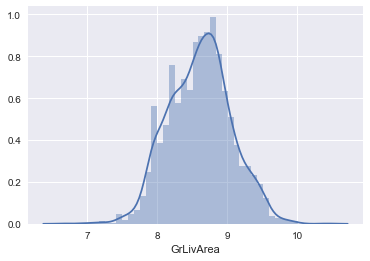

In [78]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson',standardize=False, copy=False)
#test = data[skewed_features]
#print(skewed_features)

data[skewed_features] = pt.fit_transform(data[skewed_features])

sns.distplot(data['GrLivArea'])
(mu, sigma) = norm.fit(data['GrLivArea'])
print('The mu and sigma of GrLivArea are: {}, {}'.format(mu, sigma))


#for col in skewed_features:
#    fig = plt.figure()
#    prob = stats.probplot(test[col], rvalue=True, plot=plt)
#    plt.title(col)
#    plt.show()


In [79]:
#test2 = data[skewed_features]
#test2 = np.log1p(test2)
#for col in test2.columns:
#    fig = plt.figure()
#    prob = stats.probplot(test2[col], rvalue=True, plot=plt)
#    plt.title(col)
#    plt.show()

Some of the data is still categorical and cannot be used in a regression model. Pandas has a get_dummies function which can convert the categorical data to numerical through one-hot encoding. __Note:__ Read up on dummy variable trap? Possible that by one-hot encoding, the variables could become collinear and ruin the regression model as one variable can be used to predict another. 

In [80]:
data = pd.get_dummies(data)
print('Size of all data after one-hot encoding: {}'.format(data.shape))

Size of all data after one-hot encoding: (2915, 244)


Now some of the data has been transformed and normalized using the PowerTransformer method. I am not entirely sure at this point if I should apply RobustScaler() to all of the data or just the data that was not skewed. My 

In [81]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
data = rs.fit_transform(data)


In [82]:
ptrain = data[:train.shape[0]]
ptest = data[train.shape[0]:]

print('The size of the training data was {}'.format(train.shape))
print('The size of processed training data is {}'.format(ptrain.shape))
print('The size of the test data was {}'.format(test.shape))
print('The size of processed test data is {}'.format(ptest.shape))
print('The number of targets/labels: {}'.format(target.shape))

The size of the training data was (1456, 79)
The size of processed training data is (1456, 244)
The size of the test data was (1459, 79)
The size of processed test data is (1459, 244)
The number of targets/labels: (1456,)


# Applying linear regression algorithms
Since the data is now processed, linear regression algorithms can be applied. We can try with various ones, such as Lasso, Ridge Regression and ElasticNet. 

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(ptrain)
    
def rmse_cv(estimator):
    rmse = np.sqrt(-cross_val_score(estimator, ptrain, target, scoring='neg_mean_squared_error', cv=kf).mean())
    return rmse

def learning_curves(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=kf, 
                                                           scoring='neg_mean_squared_error', 
                                                           random_state=0)
    train_mean_scores = np.sqrt(np.mean(-train_scores, axis=1))
    validation_scores = np.sqrt(np.mean(-test_scores, axis=1))
    print('Mean RMSE:', train_mean_scores)
    print('Validation scores:', validation_scores)
    print('Training sizes: {}'.format(train_sizes))
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_mean_scores, label='Training Error')
    plt.plot(train_sizes, validation_scores,label='Validation Error')
    plt.legend()
    plt.ylabel('RMSE')
    plt.xlabel('Training Size')
    plt.title('Learning curve: '+ str(estimator).split('(')[0].format(estimator))
    plt.show()


RMSE_values = []

In [84]:
elasticcv = ElasticNetCV(cv=5, random_state=0)
elasticcv.fit(ptrain, target)
print('alpha: {}'.format(elasticcv.alpha_))
print('score: {}'.format(elasticcv.score(ptrain,target)))


alpha: 0.0028688529243959776
score: 0.9252748844242762


In [85]:
elastic = ElasticNet(alpha=elasticcv.alpha_, random_state=0)
elastic.fit(ptrain, target)
print('The RMSE value for ElasticNet is: {}'.format(rmse_cv(elastic)))
RMSE_values.append(['ElasticNet', rmse_cv(elastic)])

The RMSE value for ElasticNet is: 0.11461793511939275


Mean RMSE: [0.06506984 0.09431032 0.10548453 0.1064308  0.10706011]
Validation scores: [0.13897259 0.11963355 0.11747917 0.11547354 0.11461654]
Training sizes: [ 116  378  640  902 1164]


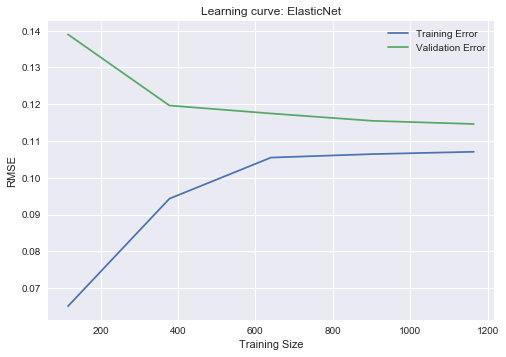

In [86]:
learning_curves(elastic, ptrain, target)

In [87]:
from sklearn.linear_model import LassoCV, Lasso

lassocv = LassoCV(cv=kf, random_state=0)
lassocv.fit(ptrain,target)
lassocv.alpha_

0.0014344264621979886

In [88]:
lasso = Lasso(alpha=lassocv.alpha_, random_state=0)
lasso.fit(ptrain, target)
print('The RMSE value for Lasso is: {}'.format(rmse_cv(lasso)))
RMSE_values.append(['Lasso', rmse_cv(lasso)])

The RMSE value for Lasso is: 0.1144556317088501


Mean RMSE: [0.0644353  0.0938958  0.10505159 0.10594343 0.10664584]
Validation scores: [0.13959664 0.11951028 0.11734537 0.11531646 0.11445523]
Training sizes: [ 116  378  640  902 1164]


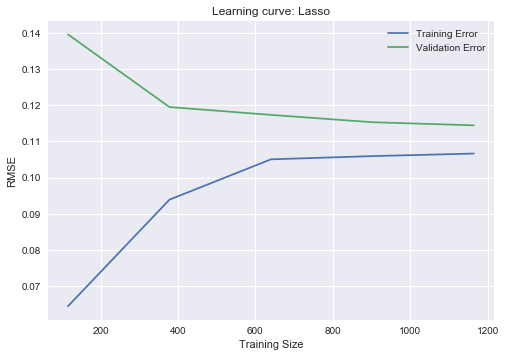

In [89]:
learning_curves(lasso, ptrain,target)

In [90]:
from sklearn.linear_model import RidgeCV, Ridge 

ridgecv = RidgeCV(cv=kf)
ridgecv.fit(ptrain,target)
ridgecv.alpha_

10.0

In [91]:
ridge = Ridge(alpha=ridgecv.alpha_, random_state=0)
ridge.fit(ptrain,target)
print('The RMSE value for Ridge is: {}'.format(rmse_cv(ridge)))
RMSE_values.append(['Ridge', rmse_cv(ridge)])

The RMSE value for Ridge is: 0.11121418584946945


Mean RMSE: [0.06899714 0.08432187 0.09426852 0.09501886 0.09590092]
Validation scores: [0.13905149 0.119584   0.11637457 0.11322943 0.11121752]
Training sizes: [ 116  378  640  902 1164]


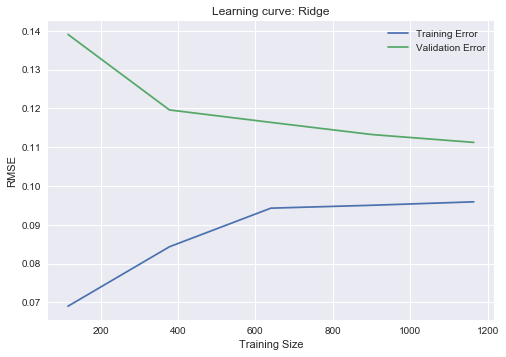

In [92]:
learning_curves(ridge, ptrain, target)

The RMSE value for KernelRidge is: 0.1936341097271808
Mean RMSE: [0.00030081 0.06168347 0.08228843 0.08692968 0.08974384]
Validation scores: [1.37500728 0.43318406 0.37978699 0.28493197 0.19364613]
Training sizes: [ 116  378  640  902 1164]


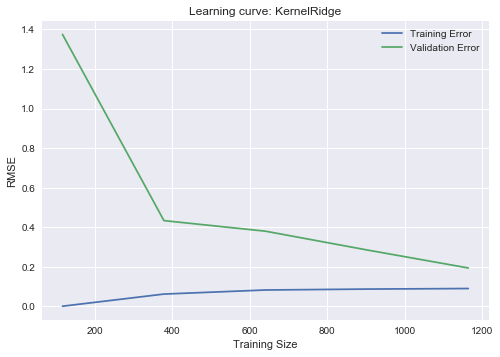

In [93]:
from sklearn.kernel_ridge import KernelRidge

kr = KernelRidge(alpha=0.0001)
kr.fit(ptrain,target)
print('The RMSE value for KernelRidge is: {}'.format(rmse_cv(kr)))
learning_curves(kr, ptrain,target)
RMSE_values.append(['KernelRidge', rmse_cv(kr)])

The RMSE value for RandomForestRegressor is: 0.14157999559963422
Mean RMSE: [0.06867666 0.05778419 0.05682139 0.05494596 0.05323695]
Validation scores: [0.18661314 0.15469183 0.148704   0.14544301 0.142074  ]
Training sizes: [ 116  378  640  902 1164]


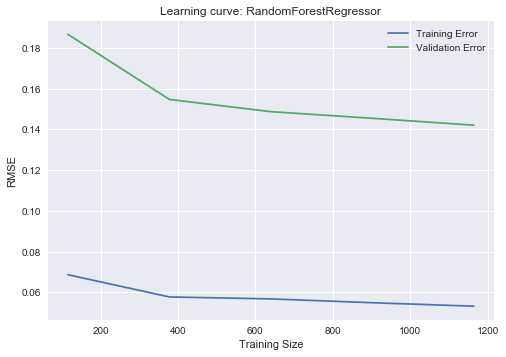

In [94]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_leaf_nodes=1000)
rf.fit(ptrain,target)
print('The RMSE value for RandomForestRegressor is: {}'.format(rmse_cv(rf)))
learning_curves(rf, ptrain,target)

In [95]:
RMSE_values.append(['RandomForestRegressor', rmse_cv(rf)])

The RMSE value for AdaBoostRegresor is: 0.13851995579403956
Mean RMSE: [0.00436196 0.00915059 0.014448   0.01856791 0.02101506]
Validation scores: [0.17709405 0.15030059 0.1467145  0.14145073 0.1392949 ]
Training sizes: [ 116  378  640  902 1164]


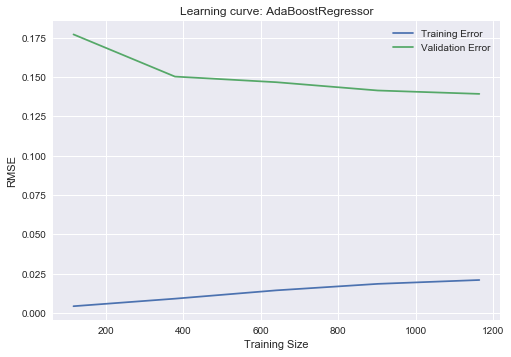

In [96]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ar = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=100, random_state=0)
ar.fit(ptrain,target)
print('The RMSE value for AdaBoostRegresor is: {}'.format(rmse_cv(ar)))
learning_curves(ar, ptrain,target)


In [97]:
RMSE_values.append(['AdaBoost', rmse_cv(ar)])

In [102]:
RMSE_df = pd.DataFrame(RMSE_values, columns=['Model','RMSE']).sort_values('RMSE')
RMSE_df

,Model,RMSE
2,Ridge,0.111214
1,Lasso,0.114456
0,ElasticNet,0.114618
5,AdaBoost,0.138520
4,RandomForestRegressor,0.139698
3,KernelRidge,0.193634


Given the above, I will try to take the top five regression models and make a prediction on the test dataset and then take the average. This will give me a baseline of the predictions. A better method of doing this would be to either stack the regressions, weight them in some way, or probably use a neural network. 

In [108]:
# Predictions:
ridge_pred = ridge.predict(ptest)
lasso_pred = lasso.predict(ptest)
elastic_pred = elastic.predict(ptest)
ar_pred = ar.predict(ptest)
rf_pred = rf.predict(ptest)

pred_dict = {'Ridge':ridge_pred, 'Lasso':lasso_pred, 'ElasticNet':elastic_pred, 'AdaBoost':ar_pred,
            'RandomForest':rf_pred}

predictions = pd.DataFrame(data=pred_dict)


In [115]:
predictions['Mean'] = predictions.mean(axis=1)
predictions

,Ridge,Lasso,ElasticNet,AdaBoost,RandomForest,Mean
0,11.674027,11.656630,11.655400,11.736069,11.757054,11.695836
1,11.985657,11.990531,11.991058,11.930120,11.940486,11.967570
2,12.123652,12.115348,12.115138,12.119137,12.091921,12.113039
3,12.186015,12.198211,12.198234,12.111367,12.109879,12.160742
4,12.188277,12.122752,12.122799,12.161916,12.201299,12.159409
5,12.028288,12.046917,12.046444,12.091721,12.129332,12.068540
6,12.068607,12.100741,12.102017,11.993117,12.034542,12.059805
7,11.976334,11.995412,11.995966,12.055970,12.081379,12.021012
8,12.194167,12.225104,12.225225,12.142670,12.140095,12.185452
9,11.654965,11.645116,11.644251,11.697445,11.685803,11.665516


In [134]:
submission_dict = {'Id':test_id, 'SalePrice':np.exp(predictions['Mean'])}
hp5_submission = pd.DataFrame(submission_dict)
hp5_submission.to_csv('hp5_submission', index=False)